In [1]:
from math import ceil
from joblib import Memory
from datetime import timedelta
import pickle
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from mmocc.config import (
    fig_column_width,
    fig_page_width,
    golden_ratio,
    silver_ratio,
    bronze_ratio,
    default_image_backbone,
    default_sat_backbone,
    figures_path,
    image_feature_dims,
    sat_feature_dims,
    cache_path,
)
from mmocc.plot_utils import setup_matplotlib
from mmocc.train_utils import img_model_labels, sat_model_labels
from mmocc.utils import (
    get_focal_species_ids,
    powerset,
    experiment_to_filename,
    get_scientific_taxon_map,
)

setup_matplotlib()

# disable jax pre-allocation
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

figures_dir = str(figures_path)
os.makedirs(figures_dir, exist_ok=True)
use_nonlinear_regressors = False

memory = Memory(cache_path / "joblib_figures")
memory.reduce_size(age_limit=timedelta(days=30))


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df

In [2]:
image_backbones = [default_image_backbone]
sat_backbones = [default_sat_backbone, "graft_visdiff", "graft_expert"]

modalities = ["image", "sat", "covariates"]
modalities_subsets = [set(modalities)]


def get_experiment_paths(enable_cache_busting=True):
    experiment_paths = []
    for taxon_id in get_focal_species_ids():
        for modalities_subset in modalities_subsets:

            modality_image_backbones = (
                image_backbones if "image" in modalities_subset else [None]
            )
            modality_sat_backbones = (
                sat_backbones if "sat" in modalities_subset else [None]
            )
            for image_backbone in modality_image_backbones:
                for sat_backbone in modality_sat_backbones:

                    if (
                        image_backbone is not None
                        and image_backbone != default_image_backbone
                    ) and (
                        sat_backbone is not None
                        and sat_backbone != default_sat_backbone
                    ):
                        continue

                    filename = experiment_to_filename(
                        taxon_id,
                        modalities_subset,
                        image_backbone,
                        sat_backbone,
                        "pkl",
                    )
                    filepath = cache_path / "fit_results" / filename
                    if not filepath.exists():
                        print(f"Skipping missing experiment {filename}")
                        continue

                    if enable_cache_busting:
                        with open(filepath, "rb") as f:
                            hash = hashlib.md5(f.read()).hexdigest()
                    else:
                        hash = None
                    experiment_paths.append((filepath, hash))

    return experiment_paths


@memory.cache
def load_df(experiment_paths):
    df = []
    for filepath, _ in tqdm(experiment_paths):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
            del data["mcmc_samples"]  # dont need to keep this in df
            df.append(data)

    df = pd.DataFrame(df)

    return df


enable_cache_busting = True
df = load_df(get_experiment_paths(enable_cache_busting))
# df = pd.read_pickle(cache_path / "figure_data_graft_refit.pkl")
df_raw = df.copy()

df.to_pickle(cache_path / "figure_data_graft_refit.pkl")

df["lppd_test_norm"] = (df["lppd_test"] - df["lppd_null_test"]) / (
    df["lppd_oracle_test"] - df["lppd_null_test"]
)

df

Skipping missing experiment 00804e75-09ef-44e5-8984-85e365377d47_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 07843615-e1fc-49d8-9821-fd1d7ff2e773_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 0f2e2c41-f1bb-4cdd-8e97-ba7cffba3e86_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 16ec4010-f175-4de7-8a99-85aadec3963b_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 1db1c6e2-2ea9-45a6-ab69-a730133298eb_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 41930eb4-2283-445a-8758-1f0b2ff43cf9_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 43320a08-bf31-49a5-8213-f032311c5765_modalities_covariates_image_sat_image_dinov2_vitb14_sat_graft_expert.pkl
Skipping missing experiment 436ddf

  0%|          | 0/54 [00:00<?, ?it/s]

________________________________________________________load_df - 287.7s, 4.8min


,taxon_id,scientific_name,common_name,modalities,image_backbone,sat_backbone,limit_to_range,modalities_scaler,modalities_pca,mean_naive_occupancy_train,...,biolith_roc_auc_null_test,biolith_roc_auc_oracle_train,biolith_roc_auc_oracle_test,biolith_errors,best_params,sat_backbone_data,descriptor_source,graft_descriptor_texts,graft_descriptor_scores,lppd_test_norm
0,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,0.5,NaN,0.999684,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,1.154555
1,00804e75-09ef-44e5-8984-85e365377d47,Antilocapra americana,pronghorn,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.041719,...,0.5,NaN,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",graft,visdiff,"[open grassy field, wide sky view, open grassl...","[1.0, 1.0, 1.0, 1.0, 1.0]",1.072739
2,07843615-e1fc-49d8-9821-fd1d7ff2e773,Dasypus novemcinctus,nine-banded armadillo,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.220657,...,0.5,NaN,1.000000,[],"{'prior_type': 'normal', 'occ_params': {'loc':...",NaN,NaN,NaN,NaN,0.128027
3,07843615-e1fc-49d8-9821-fd1d7ff2e773,Dasypus novemcinctus,nine-banded armadillo,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.220657,...,0.5,NaN,1.000000,[],"{'prior_type': 'normal', 'occ_params': {'loc':...",graft,visdiff,"[large boulder on the forest floor, shaded woo...","[0.9552000164985657, 0.9380000233650208, 0.930...",0.053253
4,0f2e2c41-f1bb-4cdd-8e97-ba7cffba3e86,Lepus americanus,snowshoe hare,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.005631,...,0.5,NaN,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,0.164677
5,0f2e2c41-f1bb-4cdd-8e97-ba7cffba3e86,Lepus americanus,snowshoe hare,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.005631,...,0.5,NaN,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",graft,visdiff,"[leaf-littered forest floor, dense forest unde...","[0.9891999959945679, 0.984000027179718, 0.9819...",-0.657249
6,16ec4010-f175-4de7-8a99-85aadec3963b,Sciurus griseus,western gray squirrel,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.027778,...,0.5,NaN,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",NaN,NaN,NaN,NaN,0.249992
7,16ec4010-f175-4de7-8a99-85aadec3963b,Sciurus griseus,western gray squirrel,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.027778,...,0.5,NaN,1.000000,[],"{'prior_type': 'laplace', 'occ_params': {'loc'...",graft,visdiff,"[stream in a forest, forest stream, humid wood...","[1.0, 1.0, 0.9968000054359436, 0.9959999918937...",-0.189625
8,1db1c6e2-2ea9-45a6-ab69-a730133298eb,Tamias striatus,eastern chipmunk,"[covariates, image, sat]",dinov2_vitb14,alphaearth,True,"{'covariates': StandardScaler(), 'image': Stan...","{'covariates': PCA(n_components=26), 'image': ...",0.024390,...,0.5,NaN,1.000000,[],"{'prior_type': 'normal', 'occ_params': {'loc':...",NaN,NaN,NaN,NaN,0.524296
9,1db1c6e2-2ea9-45a6-ab69-a730133298eb,Tamias striatus,eastern chipmunk,"[covariates, image, sat]",dinov2_vitb14,graft_visdiff,

In [3]:
min_occupancy = 0.1  # TODO
low_occupancy_mask = df["mean_naive_occupancy_test"] < min_occupancy
print(
    f"Removing {df[low_occupancy_mask]['taxon_id'].nunique()} species with low occupancy (< 0.1)"
)
df = df[df["mean_naive_occupancy_test"] >= min_occupancy]

Removing 10 species with low occupancy (< 0.1)


### Compare descriptor-driven refits against the baseline

Benchmark VisDiff and expert CLIP descriptors against the default image backbone.

In [4]:
comparison_metrics = [
    "lppd_test_norm",
    "biolith_ap_test",
    "biolith_roc_auc_test",
    "lr_map_test",
    "lr_mcc_test",
]


def align_backbone(backbone: str) -> pd.DataFrame:
    return df[df["sat_backbone"] == backbone].set_index("taxon_id")[
        ["scientific_name", *comparison_metrics]
    ]


baseline_df = align_backbone(default_sat_backbone)
visdiff_df = align_backbone("graft_visdiff")
expert_df = align_backbone("graft_expert")


def summarize_against_baseline(target: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = baseline_df.index.intersection(target.index)
    merged = (
        baseline_df.loc[overlap, comparison_metrics]
        .add_suffix("_baseline")
        .join(target.loc[overlap, comparison_metrics].add_suffix(f"_{label}"))
    )
    rows = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_baseline"]
        rows.append(
            {
                "metric": metric,
                "n_species": len(deltas),
                "mean_delta": deltas.mean(),
                "median_delta": deltas.median(),
                "improved_%": 100 * (deltas > 0).mean(),
            }
        )
    return pd.DataFrame(rows)


visdiff_vs_baseline = summarize_against_baseline(visdiff_df, "visdiff")
expert_vs_baseline = summarize_against_baseline(expert_df, "expert")

visdiff_vs_baseline.round(3), expert_vs_baseline.round(3)

(                 metric  n_species  mean_delta  median_delta  improved_%
 0        lppd_test_norm         17      -0.073        -0.035      29.412
 1       biolith_ap_test         17      -0.022        -0.014      29.412
 2  biolith_roc_auc_test         17      -0.027        -0.019       5.882
 3           lr_map_test         17      -0.011        -0.014      23.529
 4           lr_mcc_test         17      -0.004         0.000      29.412,
                  metric  n_species  mean_delta  median_delta  improved_%
 0        lppd_test_norm          0         NaN           NaN         NaN
 1       biolith_ap_test          0         NaN           NaN         NaN
 2  biolith_roc_auc_test          0         NaN           NaN         NaN
 3           lr_map_test          0         NaN           NaN         NaN
 4           lr_mcc_test          0         NaN           NaN         NaN)

/tmp/ipykernel_1704875/1305512458.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


,backbone,scientific_name,delta,baseline,target
21,visdiff,Pecari tajacu,0.015,0.325,0.340
28,visdiff,Vulpes vulpes,0.007,0.391,0.398
30,visdiff,Lynx rufus,0.006,0.350,0.355
18,visdiff,Sciurus griseus,0.004,0.382,0.386
27,visdiff,Canis latrans,0.001,0.506,0.507


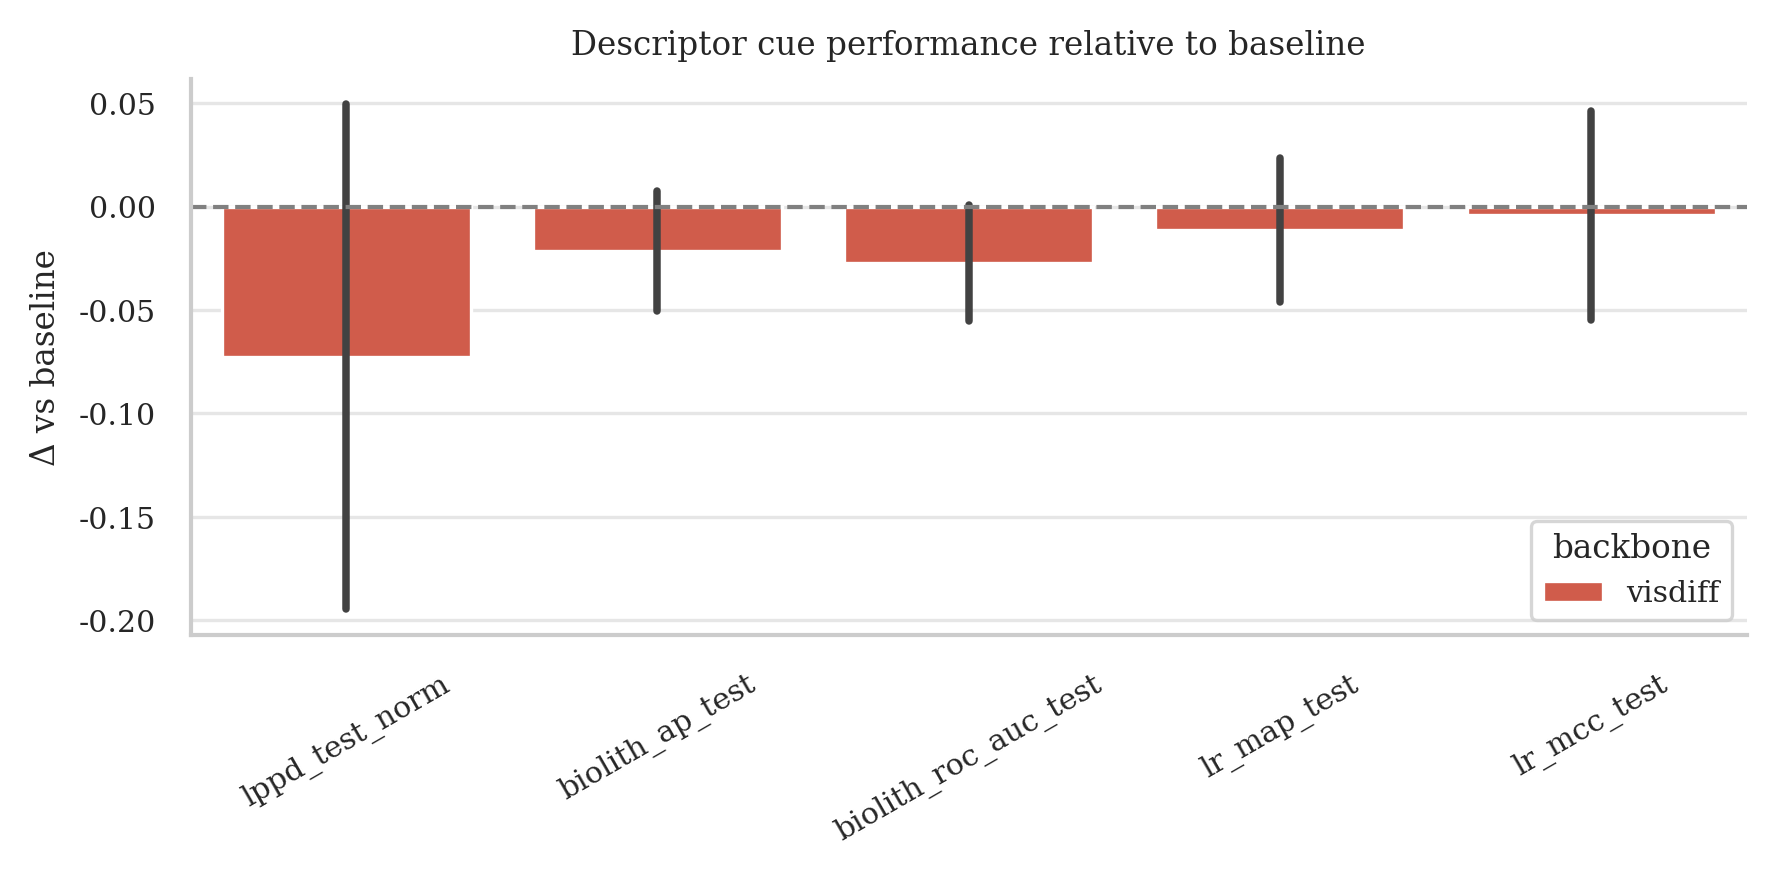

In [5]:
def build_delta_table(target: pd.DataFrame, label: str) -> pd.DataFrame:
    overlap = baseline_df.index.intersection(target.index)
    merged = (
        baseline_df.loc[overlap, ["scientific_name", *comparison_metrics]]
        .rename_axis("taxon_id")
        .join(
            target.loc[overlap, comparison_metrics],
            lsuffix="_baseline",
            rsuffix=f"_{label}",
        )
    )
    records = []
    for metric in comparison_metrics:
        deltas = merged[f"{metric}_{label}"] - merged[f"{metric}_baseline"]
        for taxon_id, delta in deltas.items():
            records.append(
                {
                    "taxon_id": taxon_id,
                    "scientific_name": merged.loc[taxon_id, "scientific_name"],
                    "metric": metric,
                    "backbone": label,
                    "delta": delta,
                    "baseline": merged.loc[taxon_id, f"{metric}_baseline"],
                    "target": merged.loc[taxon_id, f"{metric}_{label}"],
                }
            )
    return pd.DataFrame(records)


delta_long = pd.concat(
    [
        build_delta_table(visdiff_df, "visdiff"),
        build_delta_table(expert_df, "expert"),
    ],
    ignore_index=True,
)

subset = delta_long[delta_long["metric"] == "biolith_ap_test"]
top_improvements = (
    subset.sort_values(["backbone", "delta"], ascending=[True, False])
    .groupby("backbone")
    .head(5)
    .loc[:, ["backbone", "scientific_name", "delta", "baseline", "target"]]
)

fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    data=delta_long,
    x="metric",
    y="delta",
    hue="backbone",
    estimator=np.mean,
    errorbar="sd",
    ax=ax,
)
ax.axhline(0, color="gray", linewidth=1, linestyle="--")
ax.set_ylabel("Δ vs baseline")
ax.set_xlabel("")
ax.set_title("Descriptor cue performance relative to baseline")
ax.tick_params(axis="x", rotation=30)
fig.tight_layout()

top_improvements.round(3)

ValueError: zero-size array to reduction operation fmin which has no identity

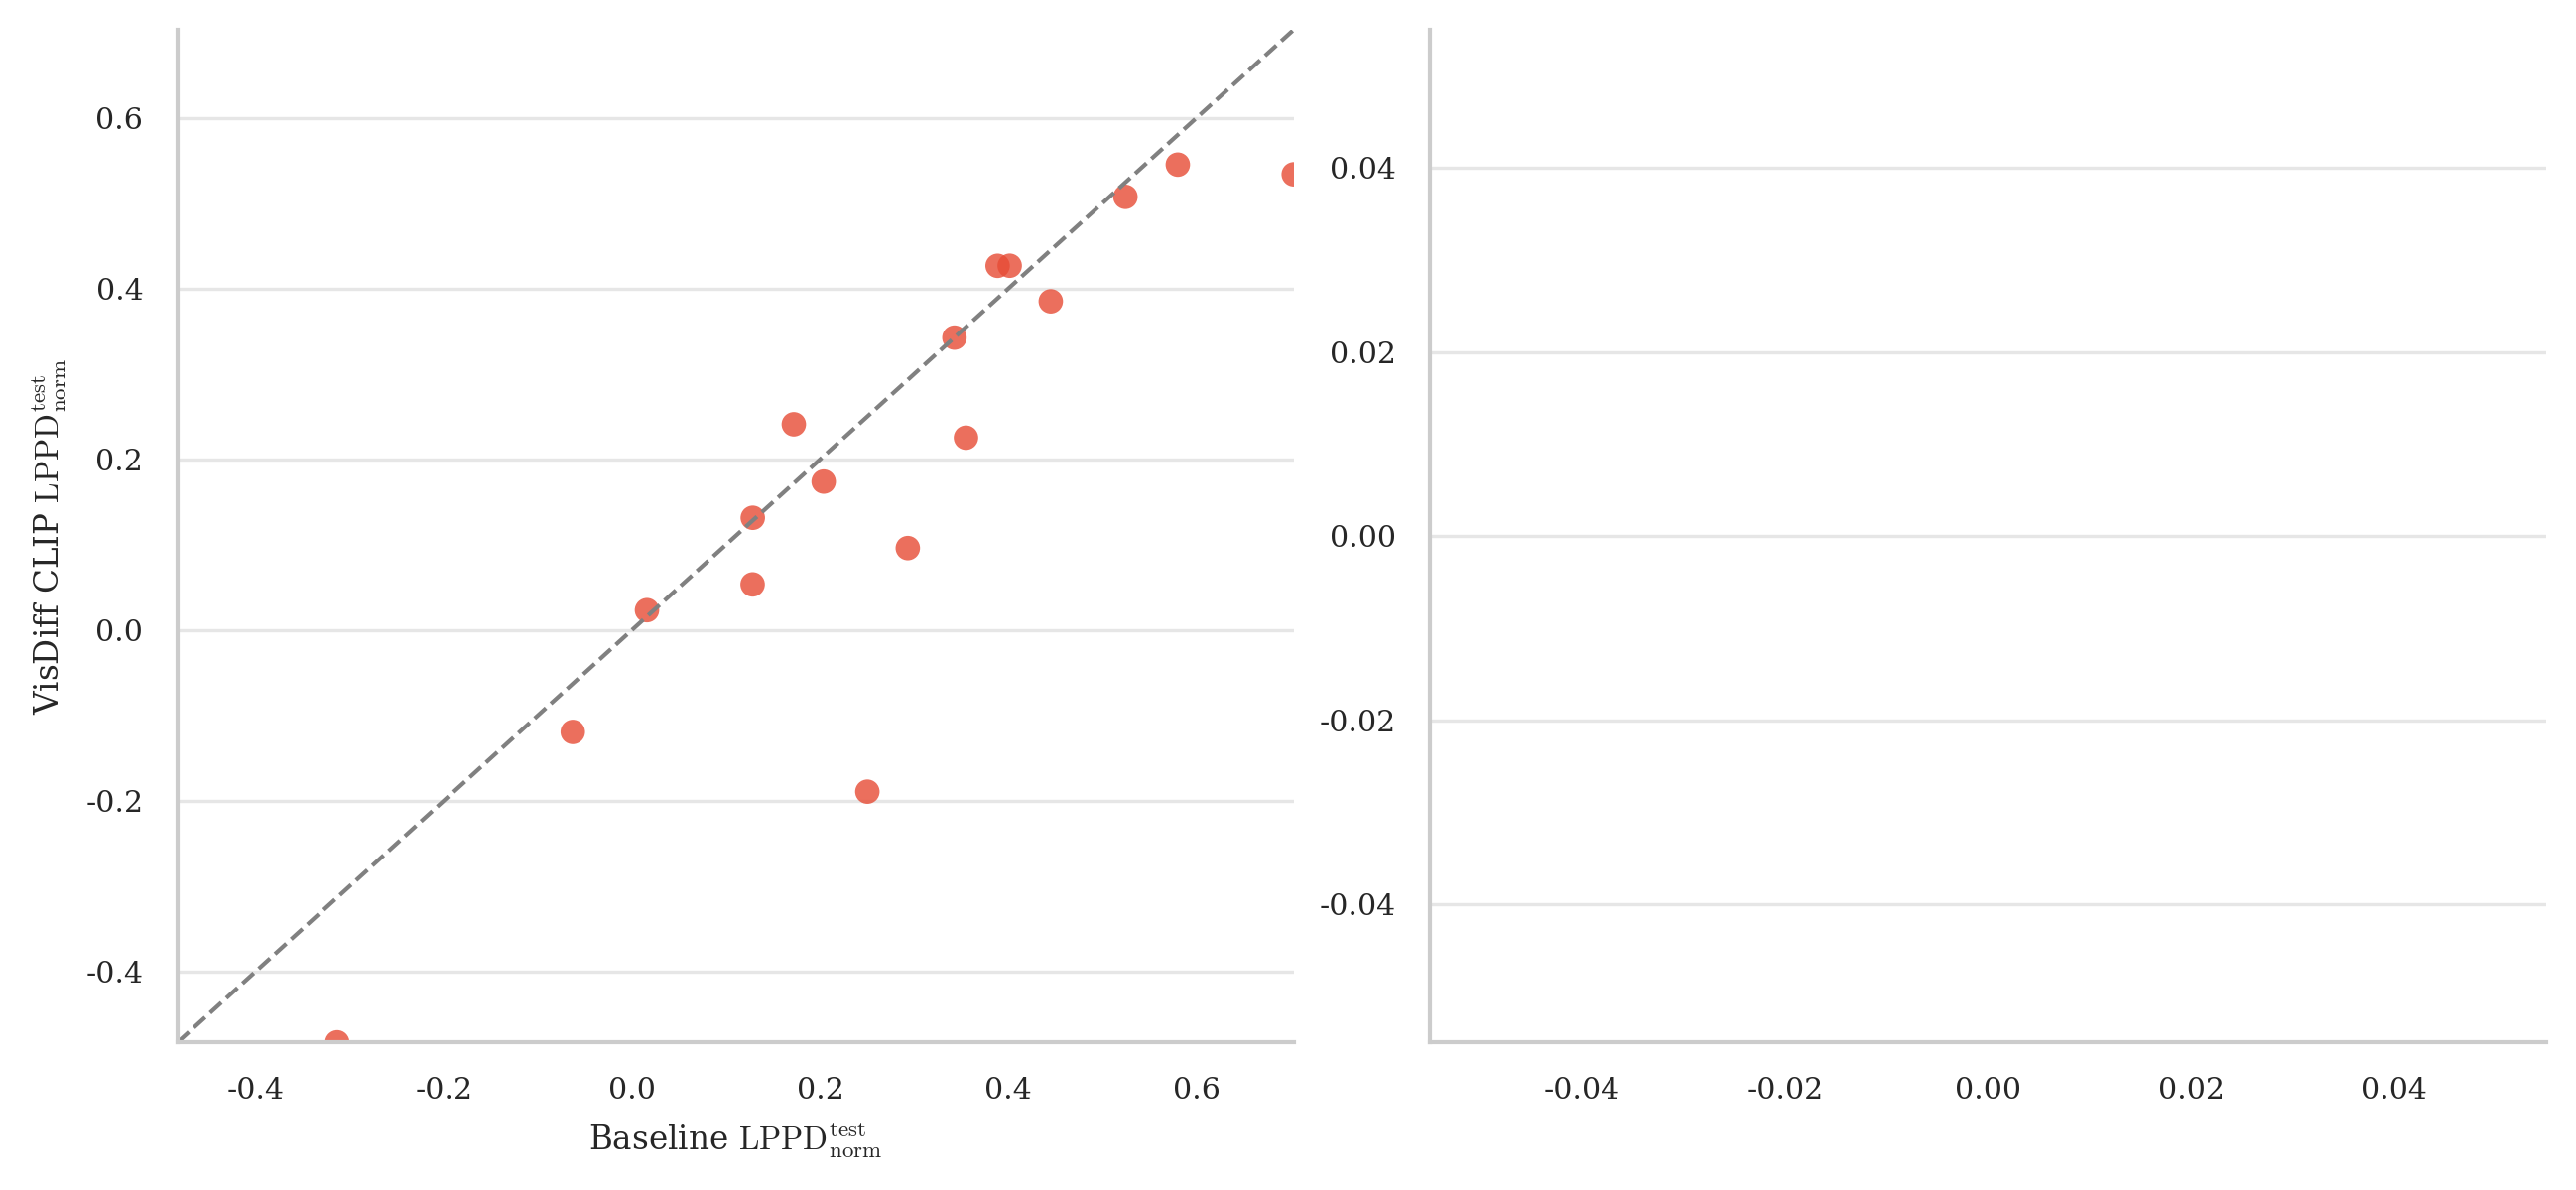

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(fig_page_width, fig_page_width / 2.2))

plot_specs = [
    ("VisDiff vs baseline", visdiff_df, "VisDiff CLIP"),
    ("Expert vs baseline", expert_df, "Expert CLIP"),
]

for ax, (title, target_df, label) in zip(axes, plot_specs):
    overlap = baseline_df.index.intersection(target_df.index)
    scatter_data = (
        baseline_df.loc[overlap, ["scientific_name", "lppd_test_norm"]]
        .rename(columns={"lppd_test_norm": "baseline"})
        .join(
            target_df.loc[overlap, ["lppd_test_norm"]].rename(
                columns={"lppd_test_norm": "target"}
            )
        )
    )

    ax.scatter(
        scatter_data["baseline"],
        scatter_data["target"],
        s=35,
        alpha=0.8,
        edgecolor="none",
    )

    lims = [
        np.nanmin(scatter_data[["baseline", "target"]].values),
        np.nanmax(scatter_data[["baseline", "target"]].values),
    ]
    ax.plot(lims, lims, linestyle="--", color="gray", linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel(r"Baseline $\text{LPPD}_\text{norm}^\text{test}$")
    ax.set_ylabel(label + r" $\text{LPPD}_\text{norm}^\text{test}$")

fig.tight_layout()
fig.savefig(
    f"{figures_dir}/graft_refit_lppd_comparison.pdf", bbox_inches="tight", transparent=True
)

print(
    f"Average improvement in LPPD (normalized): {visdiff_vs_baseline[visdiff_vs_baseline['metric']=='lppd_test_norm']['mean_delta'].values[0]:.3f} (VisDiff), {expert_vs_baseline[expert_vs_baseline['metric']=='lppd_test_norm']['mean_delta'].values[0]:.3f} (Expert)"
)

In [ ]:
df.iloc[df["lppd_test_norm"].argmin()].to_dict()

{'taxon_id': 'febff896-db40-4ac8-bcfe-5bb99a600950',
 'scientific_name': 'Odocoileus hemionus',
 'common_name': 'mule deer',
 'modalities': ['covariates', 'image', 'sat'],
 'image_backbone': 'expert_clip',
 'sat_backbone': 'alphaearth',
 'limit_to_range': True,
 'modalities_scaler': {'covariates': StandardScaler(),
  'image': StandardScaler(),
  'sat': StandardScaler()},
 'modalities_pca': {'covariates': PCA(n_components=26),
  'image': PCA(n_components=5),
  'sat': PCA(n_components=64)},
 'mean_naive_occupancy_train': 0.17104714226115977,
 'mean_naive_occupancy_test': 0.2707948243992606,
 'naive_detection_prob_train': 0.7152495537699985,
 'naive_detection_prob_test': 0.46767153244266274,
 'mean_num_observations_train': 0.17375565610859728,
 'mean_num_observations_test': 0.13896699718810124,
 'mean_num_nonnan_train': 8840,
 'mean_num_nonnan_test': 6757,
 'test_sites_too_close': 1858,
 'lr_mcc_test': -0.32232617712834816,
 'lr_precision_test': 0.0990990990990991,
 'lr_recall_test': 0.15